## Caricamento librerie, dati e funzioni custom

In [63]:
import os
from google.colab import drive
import tarfile
from shutil import copyfile
from time import time
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import IPython.display as ipd # Notebook only
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras
import warnings
import pickle
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from librosa.display import specshow


warnings.filterwarnings('ignore')
#warnings.resetwarnings()

In [ ]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/Colab Notebooks/cough_audio.tar', 'cough_audio.tar')
tar = tarfile.open('cough_audio.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_dir = '/content/archive/'
metadata_file = "metadata_compiled.csv"
metadata=pd.read_csv(data_dir+metadata_file,sep=",")

In [ ]:
# calcolo matrice di mfcc
def feats_mfcc(namefile, tsize=350):
    input,sr=librosa.load(namefile)
    mfccs=librosa.feature.mfcc(y=input*1.0,sr=sr,n_mfcc=20)
    if (tsize > mfccs.shape[1]):
      z = np.zeros((mfccs.shape[0], tsize-mfccs.shape[1]))      # dove necessario creo matrice di zeri
      mfccs = np.append(mfccs, z, axis=1)                       # e ne faccio l'append alla matrice mfccs
    mfccs = mfccs[:,0:tsize]                  # ritaglio la parte interessata secondo tsize

    return mfccs

In [ ]:
# calcolo matrice di mel spectrogram
def feats_mel(namefile, tsize=350):
    input,sr=librosa.load(namefile)
    mfccs=librosa.feature.melspectrogram(y=input*1.0,sr=sr,n_mels=20)
    if (tsize > mfccs.shape[1]):
      z = np.zeros((mfccs.shape[0], tsize-mfccs.shape[1]))      # dove necessario creo matrice di zeri
      mfccs = np.append(mfccs, z, axis=1)                       # e ne faccio l'append alla matrice mfccs
    mfccs = mfccs[:,0:tsize]                  # ritaglio la parte interessata secondo tsize

    return mfccs

## Esplorazione audio con tosse

In [ ]:
# Import file
file_name = data_dir + "00039425-7f3a-42aa-ac13-834aaa2b6b92" + ".webm"
if not os.path.exists(file_name):
  file_name = data_dir + "00039425-7f3a-42aa-ac13-834aaa2b6b92" + ".ogg"
sound_data,sound_rate=librosa.load(file_name)
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

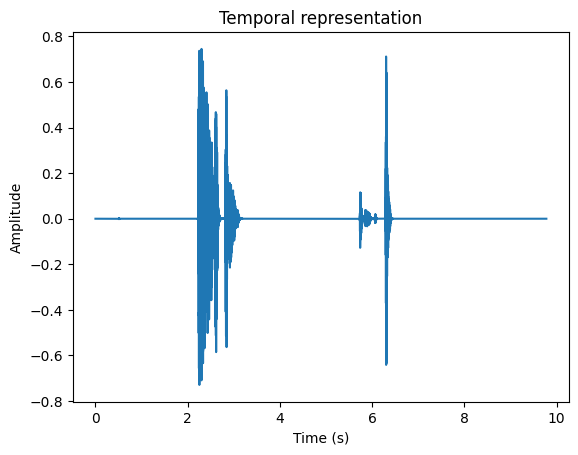

In [ ]:
# Convert sample index into the corresponding timestamp, for the plot x-axis
sound_time = np.arange(sound_data.shape[0])*1.0/sound_rate

# Visualizing a signal (temporal representation)
plt.plot(sound_time, sound_data);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Temporal representation')
plt.show()

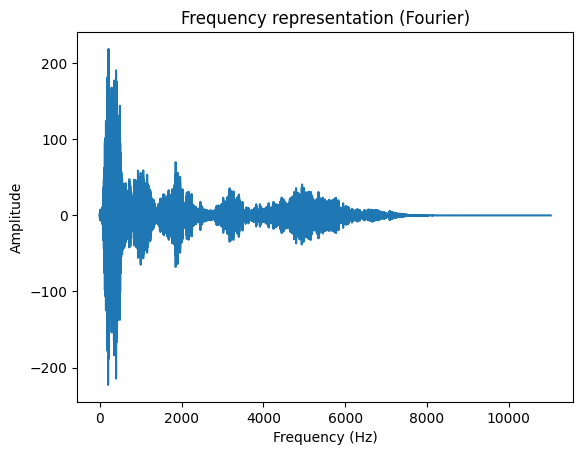

In [ ]:
# Conversion into the frequency domain
sound_rfft = rfft(sound_data)
sound_freqs = rfftfreq(len(sound_data), 1.0/sound_rate)

# Visualizing a signal (frequency representation)
plt.plot(sound_freqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.show()

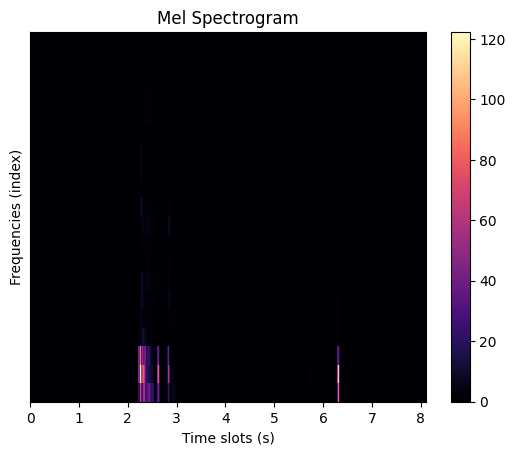

In [ ]:
# mel spec
_,sr=librosa.load(file_name)  # solo per estrazione sr
melspec = feats_mel(file_name, tsize=350)
specshow(melspec, sr=sr, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Frequencies (index)')
plt.title('Mel Spectrogram')
plt.colorbar()
plt.show()

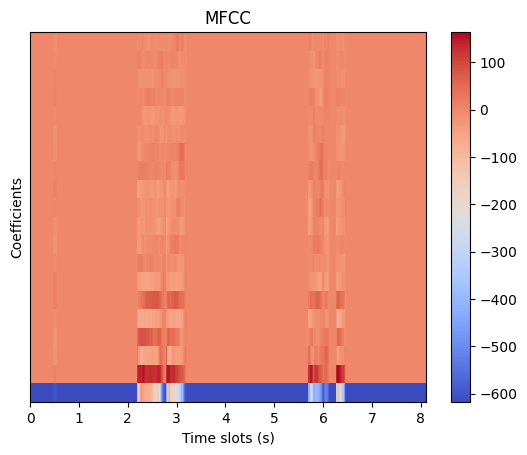

In [ ]:
# mfcc
_,sr=librosa.load(file_name)  # solo per estrazione sr
mfccs = feats_mfcc(file_name, tsize=350)
specshow(mfccs, sr=sr, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

## Esplorazione audio senza tosse

In [ ]:
# Import file
file_name = data_dir + "00981334-b1be-44f7-9d80-9318ebebc618" + ".webm"
if not os.path.exists(file_name):
  file_name = data_dir + "00981334-b1be-44f7-9d80-9318ebebc618" + ".ogg"
sound_data,sound_rate=librosa.load(file_name)
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

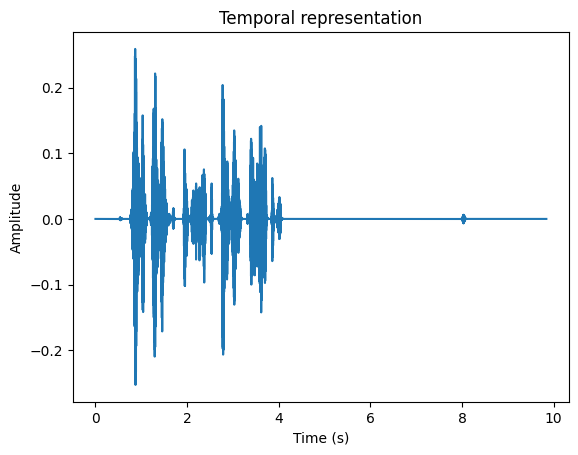

In [ ]:
# Convert sample index into the corresponding timestamp, for the plot x-axis
sound_time = np.arange(sound_data.shape[0])*1.0/sound_rate

# Visualizing a signal (temporal representation)
plt.plot(sound_time, sound_data);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Temporal representation')
plt.show()

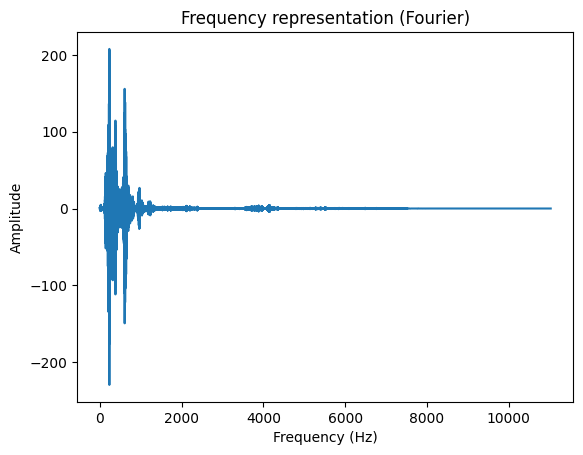

In [ ]:
# Conversion into the frequency domain
sound_rfft = rfft(sound_data)
sound_freqs = rfftfreq(len(sound_data), 1.0/sound_rate)

# Visualizing a signal (frequency representation)
plt.plot(sound_freqs, np.real(sound_rfft));
plt.xlabel('Frequency (Hz)');
plt.ylabel('Amplitude')
plt.title('Frequency representation (Fourier)')
plt.show()

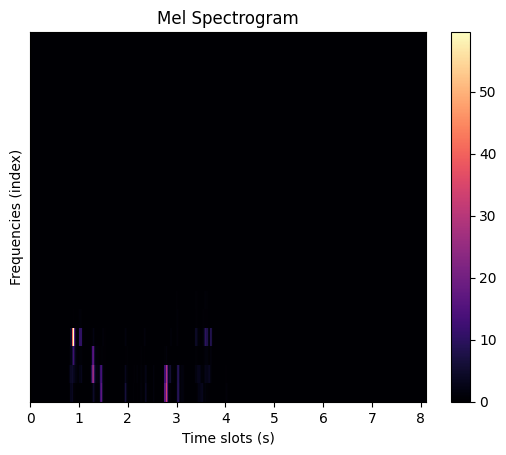

In [ ]:
# mel spec
_,sr=librosa.load(file_name)  # solo per estrazione sr
melspec = feats_mel(file_name, tsize=350)
specshow(melspec, sr=sr, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Frequencies (index)')
plt.title('Mel Spectrogram')
plt.colorbar()
plt.show()

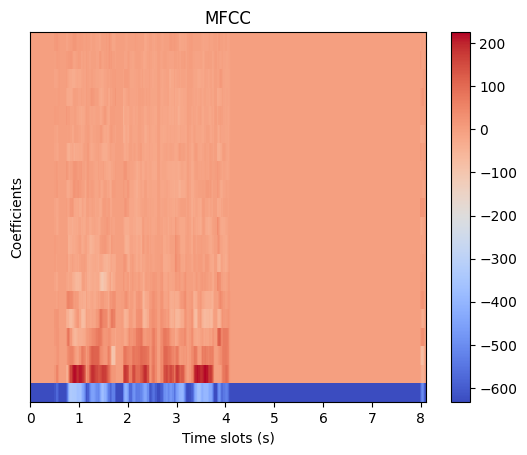

In [ ]:
# mfcc
_,sr=librosa.load(file_name)  # solo per estrazione sr
mfccs = feats_mfcc(file_name, tsize=350)
specshow(mfccs, sr=sr, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

## Preprocessing dataset e calcolo matrici mfcc/mel

In [ ]:
# elimino eventuali valori nulli o non in [0; 1]
print("metadata entries before cleaning: {}".format(metadata.shape[0]))
metadata = metadata.loc[~( (metadata['cough_detected'].isnull()) |\
  (metadata['cough_detected'] < 0) | (metadata['cough_detected'] > 1))]
print("metadata entries after cleaning: {}".format(metadata.shape[0]))

metadata entries before cleaning: 27550
metadata entries after cleaning: 27550


In [ ]:
# per classificazione biniaria approssimo a 0 i valori < 0.2 e a 1 i valori > 0.8
# ed elimino i restanti. Seleziono solo colonne uuid e cough_detected
metadata['cough_detected']=metadata['cough_detected'].apply(lambda x: 1 if x>=0.8 else 0 if x<=0.2 else 9)
metadata2=metadata[['uuid','cough_detected']]
metadata2 = metadata2.loc[~((metadata['cough_detected']) == 9)]
metadata2

,uuid,cough_detected
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,0
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,1
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,0
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,1
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,0
...,...,...
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,1
27545,fff30afc-db62-4408-a585-07ca9a254fcc,1
27547,fff474bf-39a4-4a61-8348-6b992fb5e439,0
27548,fffaa9f8-4db0-46c5-90fb-93b7b014b55d,0


[15125, 6799]


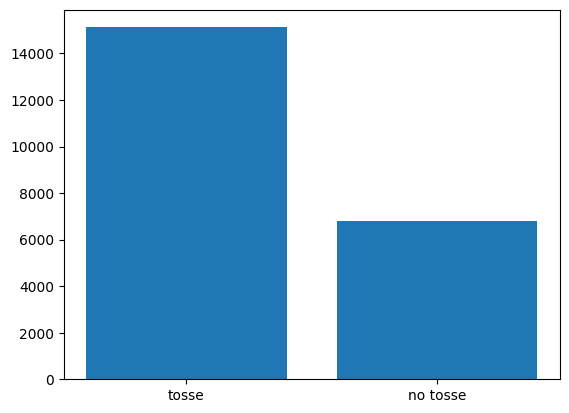

In [ ]:
count=[metadata2['cough_detected'].value_counts()[1],metadata2['cough_detected'].value_counts()[0]]
print(count)

# plot
gen=["tosse","no tosse"]
count=[metadata['cough_detected'].value_counts()[1],metadata2['cough_detected'].value_counts()[0]]
plt.bar(gen,count)
plt.show()

In [ ]:
# seleziono sottoinsieme di dataset per bilanciarlo
min = -1
if metadata2['cough_detected'].value_counts()[0] < metadata2['cough_detected'].value_counts()[1]:
  min = metadata2['cough_detected'].value_counts()[0]
else: min = metadata2['cough_detected'].value_counts()[1]

sampled_data = metadata2[metadata2['cough_detected'] == 1].sample(n=min, random_state=1)
metadata3 = pd.concat([sampled_data, metadata2[metadata2['cough_detected'] == 0]])

In [ ]:
metadata3

,uuid,cough_detected
11880,6e3053dc-65a6-4e62-8981-fa6e78a7ecc6,1
23740,dcfc95ba-b5a5-4c2f-9899-eb79953b8607,1
583,05ba535f-3c8b-4438-b976-99cb2fb014f1,1
21893,cbd36799-6ad7-4243-b1a6-7ea647de2362,1
10458,616464a2-ee80-48e0-a96b-cd4464445162,1
...,...,...
27531,ffc4f2e1-ff4f-422b-9a04-f9858d4967fb,0
27532,ffc99580-678c-46c3-8e3f-c2a19916657d,0
27536,ffd487c8-0a22-46c9-8c49-6d92901b9884,0
27547,fff474bf-39a4-4a61-8348-6b992fb5e439,0


In [ ]:
save_or_use_loaded = "use_loaded"   # impostare "save" o "use_loaded"
if save_or_use_loaded== "save":

  # estrazione feature
  extracted_feature=[]
  count = 1
  for idx,row in metadata3.iterrows():
      file_name = data_dir+row["uuid"]+".webm"
      tmp_audiofilename = row["uuid"]+".webm"
      if not os.path.exists(file_name):
          # provo altro formato
          tmp_audiofilename = row["uuid"]+".ogg"
          file_name=data_dir+row["uuid"]+".ogg"
          if not os.path.exists(file_name):
                  warnings.warn("Error! no audio for UUID: {}".format(row["uuid"]))
                  continue
      mfccs=feats_mfcc(file_name)
      mels=feats_mel(file_name)
      if count%100==0:
        print(count,"audio processed.....")
      count = count + 1
      extracted_feature.append([row["uuid"],mfccs,mels])

  # salvataggio in dataframe e file pickle
  extracted_feature_df=pd.DataFrame(extracted_feature,columns=["uuid","mfcc","mels"])
  extracted_feature_df
  with open('extracted_feat.pkl', 'wb') as file:
      pickle.dump(extracted_feature_df, file)
else:
  # caricamento di dataframe pre-calcolato
    if save_or_use_loaded=="use_loaded":
        with open('gdrive/My Drive/Colab Notebooks/extracted_feat.pkl', 'rb') as file:
           extracted_feature_df = pickle.load(file)

In [ ]:
extracted_feature_df

,uuid,mfcc,mels
0,6e3053dc-65a6-4e62-8981-fa6e78a7ecc6,"[[-532.7383422851562, -532.7383422851562, -532...","[[1.2824116937912734e-15, 6.3771748298746544e-..."
1,dcfc95ba-b5a5-4c2f-9899-eb79953b8607,"[[-598.1545, -403.235, -363.8577, -391.7922, -...","[[1.679032e-05, 0.0053919507, 0.023397902, 0.0..."
2,05ba535f-3c8b-4438-b976-99cb2fb014f1,"[[-577.2394, -577.0195, -577.12555, -577.2394,...","[[4.2510686e-07, 9.874329e-07, 6.533587e-07, 2..."
3,cbd36799-6ad7-4243-b1a6-7ea647de2362,"[[-532.31201171875, -532.31201171875, -532.312...","[[1.6050721110641019e-25, 2.938199847283957e-2..."
4,616464a2-ee80-48e0-a96b-cd4464445162,"[[-627.52026, -627.52026, -627.52026, -627.520...","[[6.782761e-09, 2.9695359e-08, 1.5562144e-08, ..."
...,...,...,...
13593,ffc4f2e1-ff4f-422b-9a04-f9858d4967fb,"[[-860.7968, -860.7968, -860.7968, -860.7968, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
13594,ffc99580-678c-46c3-8e3f-c2a19916657d,"[[-578.3442993164062, -578.3442993164062, -578...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
13595,ffd487c8-0a22-46c9-8c49-6d92901b9884,"[[-601.1305, -601.1305, -601.1305, -601.1305, ...","[[1.2824117e-15, 6.377175e-12, 1.7942483e-11, ..."
13596,fff474bf-39a4-4a61-8348-6b992fb5e439,"[[-721.4245, -721.4245, -721.4245, -721.4245, ...","[[0.0, 7.0919385e-29, 2.6832314e-10, 4.7343782..."


In [ ]:
# join con df contenente uuid e cough_detected (metadata3)
all_data = metadata3.merge(extracted_feature_df,how='inner',on="uuid")
# shuffle
all_data = all_data.sample(frac=1).reset_index(drop=True)

all_data

,uuid,cough_detected,mfcc,mels
0,a11aee5f-268c-43a8-857c-f9b3fda9c7ab,0,"[[-690.6574096679688, -519.194580078125, -463....","[[1.1502679626573808e-05, 0.000138203438837081..."
1,5a229a4b-e0ae-478c-97d5-1963cb0ac690,1,"[[-583.5634155273438, -583.5634155273438, -583...","[[1.2824116937912734e-15, 6.3771748298746544e-..."
2,0f9aa608-a6cf-472e-9ad2-b1aa193172e8,0,"[[-769.72614, -678.6036, -664.62976, -666.6016...","[[1.0541257e-05, 0.00022994234, 0.00036104312,..."
3,d169f9b0-df2f-4d17-8a5a-ad96f3ce7793,1,"[[-586.53394, -586.53394, -586.53394, -586.533...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,57453816-6585-405f-9514-43510f4219af,1,"[[-614.7638, -614.7638, -614.7638, -614.7638, ...","[[2.3690173e-08, 6.413904e-08, 9.465927e-08, 2..."
...,...,...,...,...
13593,5976dbcf-a64b-4cfa-8d0e-994a5ed053d6,1,"[[-586.3362, -527.92957, -506.36716, -525.3286...","[[0.0011465554, 0.022939496, 0.021386039, 0.00..."
13594,15f12b8d-7ba5-444e-975f-f1b26c6e75ae,1,"[[-549.8936, -549.8936, -549.8936, -549.8936, ...","[[8.964769e-10, 1.7236573e-08, 5.9897204e-08, ..."
13595,8c9beed3-d2c1-4c48-85eb-f6cf04dacb8a,0,"[[-539.47363, -539.47363, -539.47363, -539.473...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9789395e-20,..."
13596,d3dfad4e-f628-42bb-befc-a06c5d794733,0,"[[-645.9909057617188, -637.5772705078125, -255...","[[8.835129072792824e-09, 1.314935502705339e-07..."


## Allenamento modello 1: CNN con solo mfcc

In [ ]:
XIMG=np.array(all_data['mfcc'].tolist())
y=np.array(all_data['cough_detected'].tolist())

In [ ]:
# divido in train val e test
from sklearn.model_selection import train_test_split
XIMG_train,XIMG_test,y_train,y_test=train_test_split(XIMG,y,test_size=0.2,random_state=0)
XIMG_val,XIMG_test,y_val,y_test=train_test_split(XIMG_test,y_test,test_size=0.5,random_state=0)

In [ ]:
inputs = keras.Input((20,350,1))

x = inputs
x = keras.layers.Conv2D(32, 5, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(5, strides=5, padding='same')(x)

x = keras.layers.Conv2D(64, 2, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

x = keras.layers.Conv2D(128, 2, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units = 16, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.summary()
plot_model(model, to_file='modello.png', show_shapes=True)

model.compile(loss='binary_crossentropy',metrics=['binary_accuracy'],optimizer='adam')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 20, 350, 1)]      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 20, 350, 32)       832       
                                                                 
 activation_24 (Activation)  (None, 20, 350, 32)       0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 4, 70, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 4, 70, 64)         8256      
                                                                 
 activation_25 (Activation)  (None, 4, 70, 64)         0         
                                                           

In [ ]:
# Training
checkpointer = ModelCheckpoint(filepath='modelli_salvati/cnn_mfcc.hdf5', verbose=1, save_best_only=True)
num_epochs = 10
num_batch_size = 32
start = datetime.now()
history = model.fit(XIMG_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(XIMG_val, y_val), callbacks=[checkpointer],verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
337/340 [============================>.] - ETA: 0s - loss: 0.7796 - binary_accuracy: 0.5822
Epoch 1: val_loss improved from inf to 0.66610, saving model to modelli_salvati/cnn_mfcc.hdf5
340/340 [==============================] - 5s 9ms/step - loss: 0.7785 - binary_accuracy: 0.5820 - val_loss: 0.6661 - val_binary_accuracy: 0.5544
Epoch 2/10
332/340 [============================>.] - ETA: 0s - loss: 0.3753 - binary_accuracy: 0.8123
Epoch 2: val_loss improved from 0.66610 to 0.20025, saving model to modelli_salvati/cnn_mfcc.hdf5
340/340 [==============================] - 3s 8ms/step - loss: 0.3725 - binary_accuracy: 0.8141 - val_loss: 0.2003 - val_binary_accuracy: 0.9301
Epoch 3/10
332/340 [============================>.] - ETA: 0s - loss: 0.1492 - binary_accuracy: 0.9436
Epoch 3: val_loss improved from 0.20025 to 0.13238, saving model to modelli_salvati/cnn_mfcc.hdf5
340/340 [==============================] - 2s 6ms/step - loss: 0.1491 - binary_accuracy: 0.9437 - val_loss: 0.1

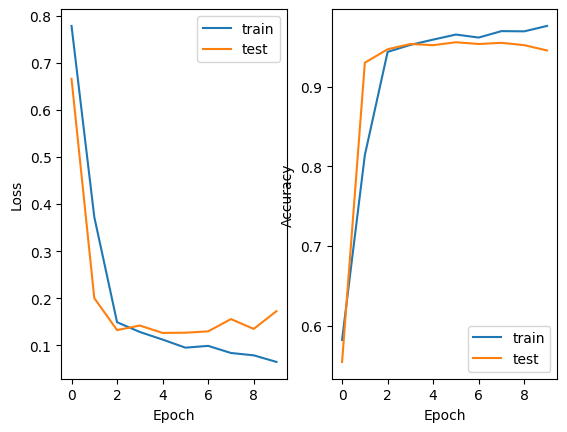

In [ ]:
# plot di loss e accuracy di train e val

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# utilizzo il modello migliore (loss minore nel val test), ottenuto durante il training
model = keras.models.load_model('modelli_salvati/cnn_mfcc.hdf5')

In [ ]:
# calcolo label test
preds = model.predict(XIMG_test)
preds = [np.round(pred) for pred in preds]

43/43 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       689
           1       0.96      0.96      0.96       671

    accuracy                           0.96      1360
   macro avg       0.96      0.96      0.96      1360
weighted avg       0.96      0.96      0.96      1360

[[663  26]
 [ 27 644]]


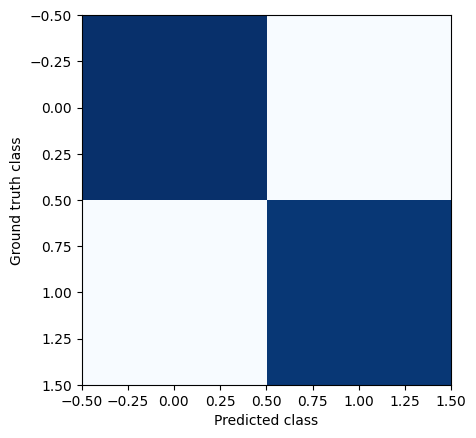

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

# Classification report
print(classification_report(y_test, preds))
print(cm)

## Allenamento modello 2: CNN con solo mel spec

In [ ]:
XIMG=np.array(all_data['mels'].tolist())
y=np.array(all_data['cough_detected'].tolist())

In [ ]:
# divido in train val e test
XIMG_train,XIMG_test,y_train,y_test=train_test_split(XIMG,y,test_size=0.2,random_state=0)
XIMG_val,XIMG_test,y_val,y_test=train_test_split(XIMG_test,y_test,test_size=0.5,random_state=0)

In [ ]:
inputs = keras.Input((20,350,1))

x = inputs
x = keras.layers.Conv2D(32, 5, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(5, strides=5, padding='same')(x)

x = keras.layers.Conv2D(64, 2, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

x = keras.layers.Conv2D(128, 2, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units = 16, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(loss='binary_crossentropy',metrics=['binary_accuracy'],optimizer='adam')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 350, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 350, 32)       832       
                                                                 
 activation_12 (Activation)  (None, 20, 350, 32)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 4, 70, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 70, 64)         8256      
                                                                 
 activation_13 (Activation)  (None, 4, 70, 64)         0         
                                                           

In [ ]:
# Training
checkpointer = ModelCheckpoint(filepath='modelli_salvati/cnn_mels.hdf5', verbose=1, save_best_only=True)
num_epochs = 10
num_batch_size = 32
start = datetime.now()
history = model.fit(XIMG_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(XIMG_val, y_val), callbacks=[checkpointer],verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
338/340 [============================>.] - ETA: 0s - loss: 0.4586 - binary_accuracy: 0.8258
Epoch 1: val_loss improved from inf to 0.34890, saving model to modelli_salvati/cnn_mels.hdf5
340/340 [==============================] - 5s 8ms/step - loss: 0.4590 - binary_accuracy: 0.8260 - val_loss: 0.3489 - val_binary_accuracy: 0.8654
Epoch 2/10
339/340 [============================>.] - ETA: 0s - loss: 0.3223 - binary_accuracy: 0.8742
Epoch 2: val_loss improved from 0.34890 to 0.30634, saving model to modelli_salvati/cnn_mels.hdf5
340/340 [==============================] - 3s 8ms/step - loss: 0.3225 - binary_accuracy: 0.8741 - val_loss: 0.3063 - val_binary_accuracy: 0.8846
Epoch 3/10
331/340 [============================>.] - ETA: 0s - loss: 0.2808 - binary_accuracy: 0.8960
Epoch 3: val_loss improved from 0.30634 to 0.28471, saving model to modelli_salvati/cnn_mels.hdf5
340/340 [==============================] - 2s 7ms/step - loss: 0.2792 - binary_accuracy: 0.8968 - val_loss: 0.2

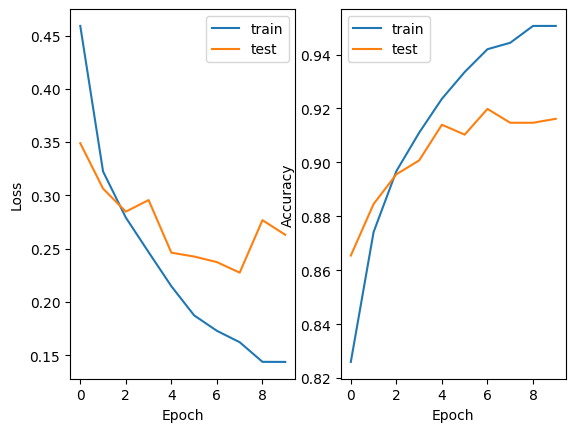

In [ ]:
# plot di loss e accuracy di train e val

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# utilizzo il modello migliore (loss minore nel val test), ottenuto durante il training
model = keras.models.load_model('modelli_salvati/cnn_mels.hdf5')

In [ ]:
# calcolo label test
preds = model.predict(XIMG_test)
preds = [np.round(pred) for pred in preds]

43/43 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       689
           1       0.95      0.92      0.94       671

    accuracy                           0.94      1360
   macro avg       0.94      0.94      0.94      1360
weighted avg       0.94      0.94      0.94      1360

[[656  33]
 [ 52 619]]


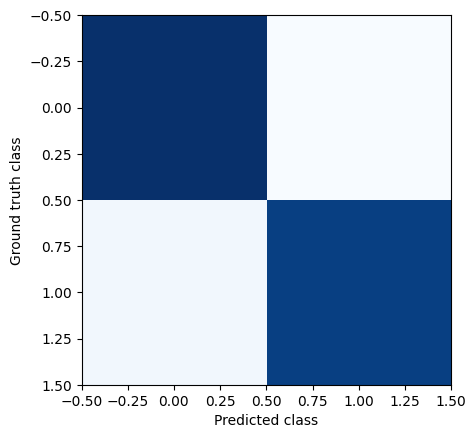

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

# Classification report
print(classification_report(y_test, preds))
print(cm)

## Allenamento modello 3: CNN con mfcc + mel spec

In [ ]:
XIMG_mfcc=np.array(all_data['mfcc'].tolist())
XIMG_mel = np.array(all_data['mels'].tolist())
y=np.array(all_data['cough_detected'].tolist())

# concateno mfcc e mel lungo direzione dei canali
XIMG_mfcc = np.expand_dims(XIMG_mfcc, axis=3)
XIMG_mel = np.expand_dims(XIMG_mel, axis=3)
XIMG = np.concatenate((XIMG_mfcc, XIMG_mel), axis=3)
print(XIMG.shape)

(13598, 20, 350, 2)


In [ ]:
# divido in train val e test
XIMG_train,XIMG_test,y_train,y_test=train_test_split(XIMG,y,test_size=0.2,random_state=0)
XIMG_val,XIMG_test,y_val,y_test=train_test_split(XIMG_test,y_test,test_size=0.5,random_state=0)

In [ ]:
import keras
inputs = keras.Input((20,350,2))

x = inputs
x = keras.layers.Conv2D(32, 5, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(5, strides=5, padding='same')(x)

x = keras.layers.Conv2D(64, 2, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

x = keras.layers.Conv2D(128, 2, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units = 32, activation = 'relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(loss='binary_crossentropy',metrics=['binary_accuracy'],optimizer='adam')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 350, 2)]      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 350, 32)       1632      
                                                                 
 activation_15 (Activation)  (None, 20, 350, 32)       0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 70, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 70, 64)         8256      
                                                                 
 activation_16 (Activation)  (None, 4, 70, 64)         0         
                                                           

In [ ]:
# Training
checkpointer = ModelCheckpoint(filepath='modelli_salvati/cnn_mfcc_mels.hdf5', verbose=1, save_best_only=True)
num_epochs = 10
num_batch_size = 32
start = datetime.now()
history = model.fit(XIMG_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(XIMG_val, y_val), callbacks=[checkpointer],verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
335/340 [============================>.] - ETA: 0s - loss: 0.4961 - binary_accuracy: 0.8046
Epoch 1: val_loss improved from inf to 0.22903, saving model to modelli_salvati/cnn_mfcc_mels.hdf5
340/340 [==============================] - 6s 8ms/step - loss: 0.4907 - binary_accuracy: 0.8069 - val_loss: 0.2290 - val_binary_accuracy: 0.9228
Epoch 2/10
337/340 [============================>.] - ETA: 0s - loss: 0.1628 - binary_accuracy: 0.9407
Epoch 2: val_loss improved from 0.22903 to 0.15491, saving model to modelli_salvati/cnn_mfcc_mels.hdf5
340/340 [==============================] - 2s 7ms/step - loss: 0.1621 - binary_accuracy: 0.9410 - val_loss: 0.1549 - val_binary_accuracy: 0.9449
Epoch 3/10
336/340 [============================>.] - ETA: 0s - loss: 0.1306 - binary_accuracy: 0.9524
Epoch 3: val_loss improved from 0.15491 to 0.13394, saving model to modelli_salvati/cnn_mfcc_mels.hdf5
340/340 [==============================] - 3s 9ms/step - loss: 0.1299 - binary_accuracy: 0.9526 

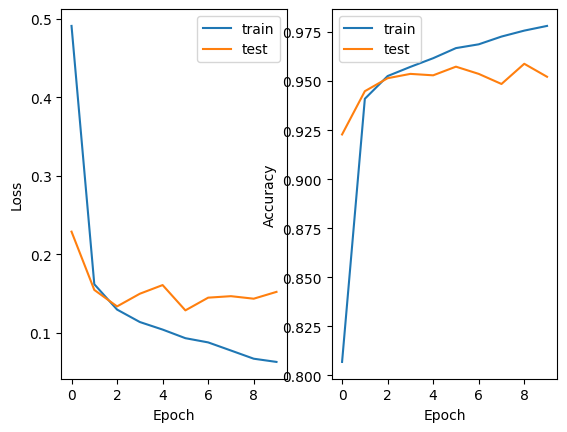

In [ ]:
# plot di loss e accuracy di train e val

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# utilizzo il modello migliore (loss minore nel val test), ottenuto durante il training
model = keras.models.load_model('modelli_salvati/cnn_mfcc_mels.hdf5')

In [ ]:
# calcolo label test
preds = model.predict(XIMG_test)
preds = [np.round(pred) for pred in preds]

43/43 [==============================] - 0s 3ms/step


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       689
           1       0.96      0.96      0.96       671

    accuracy                           0.96      1360
   macro avg       0.96      0.96      0.96      1360
weighted avg       0.96      0.96      0.96      1360

[[660  29]
 [ 27 644]]


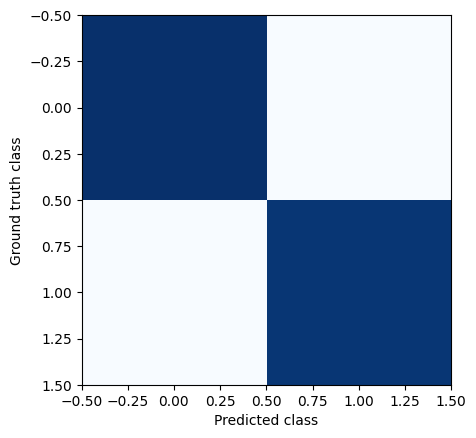

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

# Classification report
print(classification_report(y_test, preds))
print(cm)

# DEMO

In [64]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
# Import file
file_name = "gdrive/My Drive/Colab Notebooks/PROVA_TOSSE.ogg"
sound_data,sound_rate=librosa.load(file_name)
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

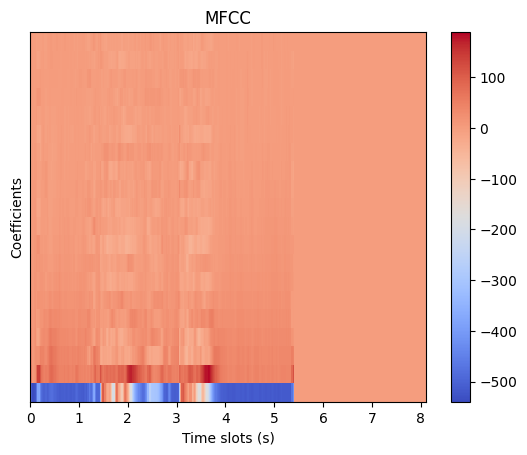

In [66]:
# mfcc
_,sr=librosa.load(file_name)  # solo per estrazione sr
mfccs = feats_mfcc(file_name, tsize=350)
specshow(mfccs, sr=sr, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

In [67]:
# Import file
file_name2 = "gdrive/My Drive/Colab Notebooks/PROVA_NO_TOSSE.ogg"
sound_data,sound_rate=librosa.load(file_name2)
# Play the signal
ipd.Audio(sound_data, rate=sound_rate)

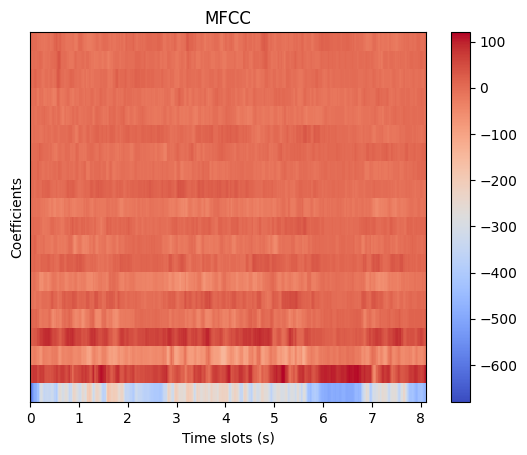

In [68]:
# mfcc
_,sr=librosa.load(file_name2)  # solo per estrazione sr
mfccs = feats_mfcc(file_name2, tsize=350)
specshow(mfccs, sr=sr, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

Preprocessing per l'inferenza

In [69]:
XIMG_prova = np.array([feats_mfcc(file_name, tsize=350), feats_mfcc(file_name2, tsize=350)])

Load della rete con solo feature mfcc

In [70]:
model = keras.models.load_model('gdrive/My Drive/Colab Notebooks/cnn_mfcc.hdf5')

In [71]:
# calcolo label test
preds = model.predict(XIMG_prova)
preds = [np.round(pred) for pred in preds]
print(preds)

1/1 [==============================] - 0s 96ms/step
[array([1.], dtype=float32), array([0.], dtype=float32)]


Predizione corretta per entrambi i file:
[1,0] (tosse, no tosse)
